### Histopathologic Cancer Detection

In this project, the aim is to build a Convolution Neural Network Algorithm to identify the metastatic cancer in small image subsets from larger digital pathological scans. 
The dataset come from Kaggle Competition [https://www.kaggle.com/competitions/histopathologic-cancer-detection/overview]. The dataset consists of RGB .tif images with dimensions of 96 by 96 pixels. Each training image has been assigned a label of 0 (benign) or 1 (cancerous). There are 220025 training images, 130908 with label of 0 and 89117 with label of 1. I will use 85% for training and 15% for validation. For the CNN model build and training process, I will be using `tensorflow.keras` [https://www.tensorflow.org/guide/keras].

Github Repository: https://github.com/dfu2020/DTSA-5511/tree/main/Week3

### Import Library and necessary data massaging

In [150]:
# Importing the necessary libraries
import numpy as np 
import pandas as pd 
from pathlib import Path
import json
import os
import random
from sklearn.utils import shuffle
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import matplotlib.patches as patches
from skimage.transform import rotate
from skimage import io
import cv2 as cv
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import RandomFlip, RandomZoom, RandomRotation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)

In [157]:
# Setup GPU accelerator - configure Strategy. Assume TPU...if not set default for GPU/CPU
tpu = None
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy()

In [160]:
filepath_lst = []
file_id_lst = []
for filename in os.listdir('histopathologic-cancer-detection/train/'):
    filepath = os.path.join('histopathologic-cancer-detection/train/', filename)
    file_id, _ = os.path.splitext(filename)
    file_id_lst.append(file_id)
    filepath_lst.append(filepath)

In [161]:
training_label=pd.DataFrame({'filepath': filepath_lst})
training_label.loc[:,'id']= file_id_lst
labels = pd.read_csv('histopathologic-cancer-detection/train_labels.csv') 

In [162]:
train_file_labels = pd.merge(left=training_label,
                    right=labels,
                    how='left',
                    on='id')

In [163]:
train_file_labels 

,filepath,id,label
0,histopathologic-cancer-detection/train/f0c2a0b...,f0c2a0b8ef3024f407fa97d852d49be0215cafe0,0
1,histopathologic-cancer-detection/train/99ef485...,99ef485f205645918613cd04281098daa7c17819,1
2,histopathologic-cancer-detection/train/e2612e1...,e2612e173abd0e8bb54a3c3db3f264b63d80bffb,1
3,histopathologic-cancer-detection/train/6d1bb57...,6d1bb57c0606f05dbd75f90a8d9e21a57e1267e0,0
4,histopathologic-cancer-detection/train/9c043ab...,9c043ab2adadfeb758c71d21432fccd3e43565c0,1
...,...,...,...
220020,histopathologic-cancer-detection/train/7a5f23a...,7a5f23a002018cd828cc5e8df89de79850d01050,1
220021,histopathologic-cancer-detection/train/7cd369c...,7cd369c04a37c9da20bbfe1bcba2cfad754fc100,1
220022,histopathologic-cancer-detection/train/b21c0dc...,b21c0dc5ba97639f3b5c62ffe00364cfb0c11b40,0
220023,histopathologic-cancer-detection/train/d16dbda...,d16dbdaf3b5cea4b5f6629e2a487f0e01075ba58,0


### Basic EDA

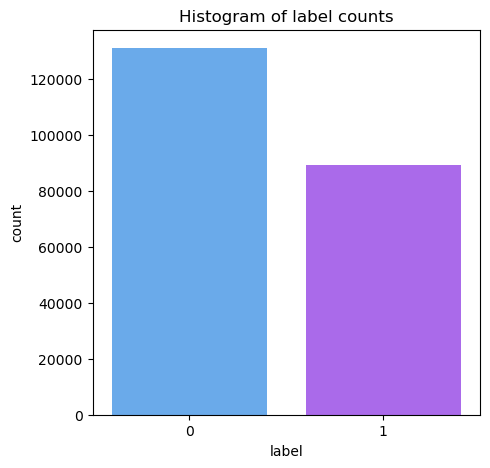

In [156]:
# Create a histogram of the counts of both labels
plt.figure(figsize=(5,5))
sns.countplot(x=train_file_labels['label'], palette='cool').set(title='Histogram of label counts')
plt.show()

In [14]:
# Create a function to plot random samples from both label categories
def image_plotting(df, col_name, fig_count=5):
    labels = df[col_name].unique()
    fig, ax = plt.subplots(nrows=len(labels),ncols=fig_count, 
                        figsize=(3*fig_count,3*len(labels)))
    for i, label in enumerate(labels):
        sample = df[df[col_name]==label].sample(fig_count)
        for j in range(fig_count):
            fileP =sample.iloc[j]['filepath']
            im=cv2.imread(fileP)
            ax[i, j].imshow(im, resample=True, cmap='gray')
            ax[i, j].set_title("label={}".format(label), fontsize=16)  
    plt.tight_layout()
    plt.show()

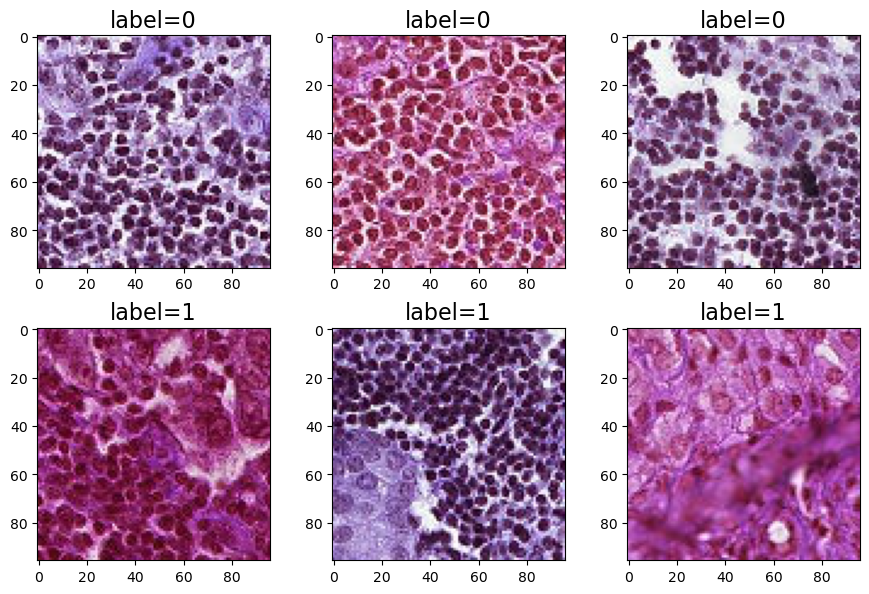

In [152]:
# plot 3 sets of sample images from two categories
image_plotting(train_file_labels,'label', 3)

### Build the Generators and Train Model

In [45]:
# Shuffle training data
train_file_labels = shuffle(train_file_labels, random_state=42)
# Convert labels to string
train_file_labels.label = train_file_labels.label.astype(str)

In [59]:
# Call ImageDataGenerator to rescale the RGB image to
# between [0,1], and perform a validation split of 0.15
datagen = ImageDataGenerator(rescale=1./255.,
                            validation_split=0.15)

In [76]:
# build the training generator
train_generator = datagen.flow_from_dataframe(
    dataframe=train_file_labels,
    directory=os.getcwd(),
    x_col="filepath",
    y_col="label",
    subset="training",
    batch_size=256,
    seed=42,
    class_mode="binary",
    target_size=(96,96)) 

Found 187022 validated image filenames belonging to 2 classes.


In [77]:
# build the validation generator
valid_generator = datagen.flow_from_dataframe(
    dataframe=train_file_labels,
    directory=os.getcwd(),
    x_col="filepath",
    y_col="label",
    subset="validation",
    batch_size=256,
    seed=42,
    class_mode="binary",
    target_size=(96,96))       # original image = (96, 96) 


Found 33003 validated image filenames belonging to 2 classes.


In [82]:
# Build the Sequential Model
with strategy.scope():kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128

dropout_conv = 0.3
dropout_dense = 0.3

model = Sequential()
model.add(Conv2D(first_filters, kernel_size, activation = 'relu', input_shape = (96, 96, 3)))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(MaxPooling2D(pool_size = pool_size)) 
model.add(Dropout(dropout_conv))

model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(dropout_dense))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 94, 94, 32)        896       
                                                                 
 conv2d_19 (Conv2D)          (None, 92, 92, 32)        9248      
                                                                 
 conv2d_20 (Conv2D)          (None, 90, 90, 32)        9248      
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 dropout_8 (Dropout)         (None, 45, 45, 32)        0         
                                                                 
 conv2d_21 (Conv2D)          (None, 43, 43, 64)        18496     
                                                      

In [84]:
# Choose ROC AUC as a training/validation metric
roc = tf.keras.metrics.AUC()

#compile the model
adam_optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001)
model.compile(loss='binary_crossentropy', metrics=['accuracy', roc], optimizer=adam_optimizer)

# choose a EPOCH size of 20
EPOCHS = 20

# train the model
history_model = model.fit(
                        train_generator,
                        epochs = EPOCHS,
                        validation_data = valid_generator)

Epoch 1/20
731/731 [==============================] - 1531s 2s/step - loss: 0.4766 - accuracy: 0.7747 - auc_2: 0.8455 - val_loss: 0.4585 - val_accuracy: 0.7878 - val_auc_2: 0.8770
Epoch 2/20
731/731 [==============================] - 1583s 2s/step - loss: 0.4029 - accuracy: 0.8229 - auc_2: 0.8923 - val_loss: 0.6165 - val_accuracy: 0.7218 - val_auc_2: 0.9001
Epoch 3/20
731/731 [==============================] - 1604s 2s/step - loss: 0.3614 - accuracy: 0.8435 - auc_2: 0.9142 - val_loss: 0.5598 - val_accuracy: 0.7574 - val_auc_2: 0.9075
Epoch 4/20
731/731 [==============================] - 1625s 2s/step - loss: 0.3321 - accuracy: 0.8575 - auc_2: 0.9281 - val_loss: 0.5514 - val_accuracy: 0.7670 - val_auc_2: 0.9282
Epoch 5/20
731/731 [==============================] - 1509s 2s/step - loss: 0.3091 - accuracy: 0.8692 - auc_2: 0.9378 - val_loss: 0.4519 - val_accuracy: 0.8000 - val_auc_2: 0.9396
Epoch 6/20
731/731 [==============================] - 1515s 2s/step - loss: 0.2955 - accuracy: 0.875

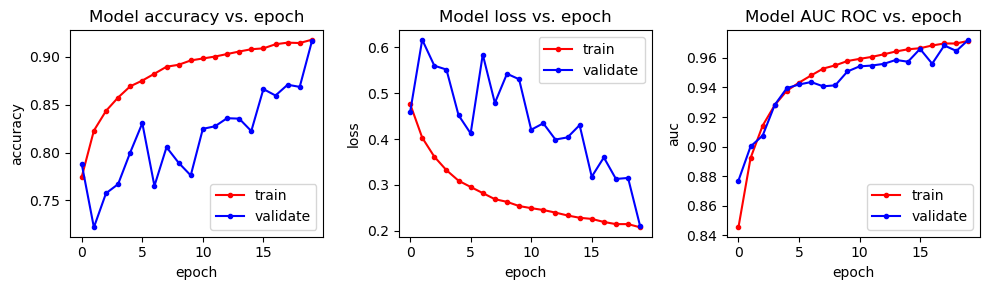

In [159]:
fig, ((ax1, ax2,ax3)) = plt.subplots(nrows= 1,ncols=3, figsize=(10,3))
ax1.plot(history_model.history['accuracy'], marker='.',color='red', label='train')
ax1.plot(history_model.history['val_accuracy'], marker='.',color='blue', label='validate')
ax1.legend()
ax1.set_xlabel('epoch')
ax1.set_ylabel('accuracy')
ax1.set_title('Model accuracy vs. epoch')

ax2.plot(history_model.history['loss'], marker='.',color='red', label='train')
ax2.plot(history_model.history['val_loss'], marker='.',color='blue', label='validate')
ax2.legend()
ax2.set_xlabel('epoch')
ax2.set_ylabel('loss')
ax2.set_title('Model loss vs. epoch')
plt.tight_layout()

ax3.plot(history_model.history['auc_2'], marker='.',color='red', label='train')
ax3.plot(history_model.history['val_auc_2'], marker='.',color='blue', label='validate')
ax3.legend()
ax3.set_xlabel('epoch')
ax3.set_ylabel('auc')
ax3.set_title('Model AUC ROC vs. epoch')
plt.tight_layout()

### Generate predictions for submission

In [158]:
test_path = 'histopathologic-cancer-detection/test/'
#create a dataframe to run the predictions
test_df = pd.DataFrame({'id':os.listdir(test_path)})
test_df.head(10)

,id
0,fd0a060ef9c30c9a83f6b4bfb568db74b099154d.tif
1,1f9ee06f06d329eb7902a2e03ab3835dd0484581.tif
2,19709bec800f372d0b1d085da6933dd3ef108846.tif
3,7a34fc34523063f13f0617f7518a0330f6187bd3.tif
4,93be720ca2b95fe2126cf2e1ed752bd759e9b0ed.tif
5,761dde7de22cb39a0dd67ce472163d66e5ac1568.tif
6,58055ce8819717a100b48d019e139be4fdf997c0.tif
7,9735b584631f4b942b022d40aecdbe2aa8f6ae5e.tif
8,860bbd33f8483a45858c4998021bc7434117deda.tif
9,99050fbce64ae16e48e8a3b09d38f3b16df63fbe.tif


In [95]:
# Build the test generator
test_datagen = ImageDataGenerator(rescale=1./255.)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=test_path,
    x_col='id', 
    y_col=None,
    target_size=(96,96),     
    batch_size=1,
    shuffle=False,
    class_mode=None)

Found 57458 validated image filenames.


In [96]:
# Perform the predictions by calling the model.
predictions = model.predict(test_generator, verbose=1)

57458/57458 [==============================] - 367s 6ms/step


In [98]:
# Create a dataframe for submission
predictions = np.transpose(predictions)[0]
submission_df = pd.DataFrame()
submission_df['id'] = test_df['id'].apply(lambda x: x.split('.')[0])
submission_df['label'] = list(map(lambda x: 0 if x < 0.5 else 1, predictions))
submission_df.head(10)

,id,label
0,fd0a060ef9c30c9a83f6b4bfb568db74b099154d,1
1,1f9ee06f06d329eb7902a2e03ab3835dd0484581,0
2,19709bec800f372d0b1d085da6933dd3ef108846,0
3,7a34fc34523063f13f0617f7518a0330f6187bd3,0
4,93be720ca2b95fe2126cf2e1ed752bd759e9b0ed,0


In [100]:
# Write out to .csv
submission_df.to_csv('CNN_prediction_submission.csv', index=False)

#### SUMMARY

After 20 epochs, the CNN model achieved a validation accuracy of 91.6% and AUC ROC of 0.972. After 20 epochs, the loss and the accuracy does not converge (i.e. reach a steady state), this is mostly due to the fact that the model is quite complex and we are training the model with 85% of the entire dataset, each epoch takes roughly 25 mins to run, the end results might be improved if we reduce the size of the training dataset (e.g., choose 5000 images to train), modify the batch size and increase the number of epochs. Overall, the validation accuracy 91.6% and validation AUC of 0.972 is somewhat encouraging.